In [1]:
#CNTK Image Understanding
from IPython.display import Image

In [10]:
# Figure 1
Image(url="https://cntk.ai/jup/201/cifar-10.png", width=500, height=500)

In [11]:
# Figure 2
Image(url="https://cntk.ai/jup/201/Conv2D.png")

In [12]:
# Figure 3
Image(url="https://cntk.ai/jup/201/Conv2DFeatures.png")

In [13]:
# Figure 4
Image(url="https://cntk.ai/jup/201/MaxPooling.png", width=400, height=400)

In [14]:
#Importing modules
from __future__ import print_function

import matplotlib.pyplot as plt
import math
import os
import numpy as np
import PIL
import sys
try:
    from urllib.request import urlopen
except ImportError:
    from urllib import urlopen
    
import cntk as C

In [15]:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE']=='cpu':
        C.device.try_set_dfault_device(C.device.cpu())
    else:
        C.device.try_Set_default_device(C.device.gpu(0))
    

In [22]:
#Data Reading

#Determine the path for testing
#Check for an environment variable in CNTK's test infrastructure

envvar='CNTK_EXTERNAL_TESTDATA_SOURCE_DIRECTORY'
def is_test(): return envvar in os.environ

if is_test():
    data_path=os.path.join(os.environ[envvar], 'Image', 'CIFAR', 'v0', 'tutorial1201')
    data_path=os.path.normpath(data_path)
else:
    data_path=os.path.join('data','CIFAR-10')
    
#model dimensions
image_height=32
image_width=32
num_channels=3
num_classes=10

import cntk.io.transforms as xforms

#Define the reader for both training and evaluation action

def create_reader(map_file, mean_file, train):
    print("Reading map file:", map_file)
    print("Reading mean file:", mean_file)
    
    if not os.path.exists(map_file) or not os.path.exists(mean_file):
        raise RuntimeError("This load the data first")
        
    #transformations pipeline for for the features that has jitter/crop only when training
    transforms=[]
    #train uses data augmentation (translation only)
    if train:
        transforms+=[
            xforms.crop(crop_type='randomside', side_ratio=0.8)
        ]
    transforms+=[
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
        xforms.mean(mean_file)
    ]
    
    #deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features= C.io.StreamDef(field='image', transforms=transforms), #first column in map file is referred to as 'image'
        labels=C.io.StreamDef(field='label', shape=num_classes) # and second as 'label'
    )))


In [23]:
#Create Train and Test Readers
reader_train=create_reader(os.path.join(data_path, 'train_map.txt'),
                          os.path.join(data_path, 'CIFAR-10_mean.xml'), True)
reader_test=create_reader(os.path.join(data_path, 'test_map.txt'),
                         os.path.join(data_path, 'CIFAR-10_mean.xml'), False)


Reading map file: data\CIFAR-10\train_map.txt
Reading mean file: data\CIFAR-10\CIFAR-10_mean.xml
Reading map file: data\CIFAR-10\test_map.txt
Reading mean file: data\CIFAR-10\CIFAR-10_mean.xml


In [24]:
# Figure 5
Image(url="https://cntk.ai/jup/201/CNN.png")

In [31]:
#Model Creation (Basic CNN)
def create_basic_model(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        net= C.layers.Convolution((5,5), 32, pad=True)(input)
        net=C.layers.MaxPooling((3,3), strides=(2,2))(net)
        
        net=C.layers.Convolution((5,5), 32, pad=True)(net)
        net=C.layers.Convolution((3,3), strides=(2,2))(net)
        
        net=C.layers.Dense(64)(net)
        net=C.layers.Dense(out_dims, activation=None)(net)
        
    return net

In [44]:
#Training and Evaluation

#Train and evaluate the Network
def train_and_evaluate(reader_train, reader_test, max_epochs, model_func):
    # Input variables denoting the features and label data
    input_var = C.input_variable((num_channels, image_height, image_width))
    label_var = C.input_variable((num_classes))

    # Normalize the input
    feature_scale = 1.0 / 256.0
    input_var_norm = C.element_times(feature_scale, input_var)

    # apply model to input
    z = model_func(input_var_norm, out_dims=10)

    #
    # Training action
    #

    # loss and metric
    ce = C.cross_entropy_with_softmax(z, label_var)
    pe = C.classification_error(z, label_var)

    # training config
    epoch_size     = 50000
    minibatch_size = 64

    # Set training parameters
    lr_per_minibatch       = C.learning_parameter_schedule([0.01]*10 + [0.003]*10 + [0.001],
                                                       epoch_size = epoch_size)
    momentums              = C.momentum_schedule(0.9, minibatch_size = minibatch_size)
    l2_reg_weight          = 0.001

    # trainer object
    learner = C.momentum_sgd(z.parameters,
                             lr = lr_per_minibatch,
                             momentum = momentums,
                             l2_regularization_weight=l2_reg_weight)
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
    trainer = C.Trainer(z, (ce, pe), [learner], [progress_printer])

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    C.logging.log_number_of_parameters(z) ; print()

    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count),
                                               input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it

            sample_count += data[label_var].num_samples                     # count samples processed so far

            # For visualization...
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)

            batch_index += 1
        trainer.summarize_training_progress()

    #
    # Evaluation action
    #
    epoch_size     = 10000
    minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")

    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0))
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0))

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width

    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()

    return C.softmax(z)                      

Training 32203 parameters in 10 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per 64 samples: 0.9
Finished Epoch[1 of 5]: [Training] loss = 2.274363 * 50000, metric = 83.19% * 50000 672.348s ( 74.4 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 2.123118 * 50000, metric = 77.33% * 50000 39.155s (1277.0 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 1.931071 * 50000, metric = 72.36% * 50000 38.538s (1297.4 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 1.828594 * 50000, metric = 68.11% * 50000 38.906s (1285.1 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 1.771540 * 50000, metric = 65.76% * 50000 41.501s (1204.8 samples/s);

Final Results: Minibatch[1-626]: errs = 62.0% * 10000



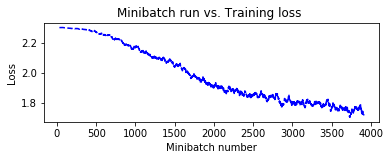

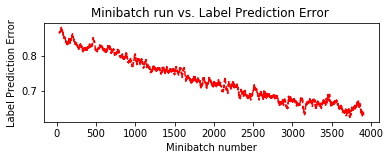

In [45]:
pred= train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_basic_model)

In [48]:
#Create basic model in terse format
def create_basic_model_terse(input, out_dims):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        model=C.layers.Sequential([
            C.layers.For(range(3), lambda i:[
                C.layers.Convolution((5,5), [32,32,64][i], pad=True),
                C.layers.MaxPooling((3,3), strides=(2,2))
                ]),
            C.layers.Dense(64),
            C.layers.Dense(out_dims, activation=None)            
        ])
    return model(input)


Training 116906 parameters in 10 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per 64 samples: 0.9
Finished Epoch[1 of 10]: [Training] loss = 2.109275 * 50000, metric = 77.21% * 50000 43.959s (1137.4 samples/s);
Finished Epoch[2 of 10]: [Training] loss = 1.721950 * 50000, metric = 63.30% * 50000 43.166s (1158.3 samples/s);
Finished Epoch[3 of 10]: [Training] loss = 1.550321 * 50000, metric = 56.83% * 50000 42.987s (1163.1 samples/s);
Finished Epoch[4 of 10]: [Training] loss = 1.452628 * 50000, metric = 52.61% * 50000 42.827s (1167.5 samples/s);
Finished Epoch[5 of 10]: [Training] loss = 1.369741 * 50000, metric = 49.15% * 50000 42.901s (1165.5 samples/s);
Finished Epoch[6 of 10]: [Training] loss = 1.292228 * 50000, metric = 45.97% * 50000 42.958s (1163.9 samples/s);
Finished Epoch[7 of 10]: [Training] loss = 1.231050 * 50000, metric = 43.70% * 50000 43.444s (1150.9 samples/s);
Finished Epoch[8 of 10]: [Training] loss = 1.185720 * 50000, metric = 42.00% * 50000 42.768s 

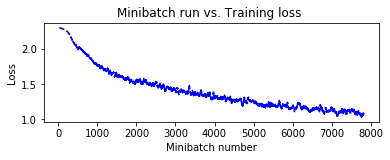

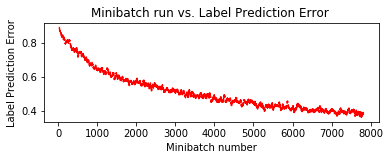

In [49]:
pred_basic_model= train_and_evaluate(reader_train, reader_test, max_epochs=10, model_func=create_basic_model_terse)

In [50]:
#We will classify the truck
# Figure 6
Image(url="https://cntk.ai/jup/201/00014.png", width=64, height=64)

In [52]:
# Download a sample image
# (this is 00014.png from test dataset)
# Any image of size 32,32 can be evaluated

url = "https://cntk.ai/jup/201/00014.png"
myimg = np.array(PIL.Image.open(urlopen(url)), dtype=np.float32)

In [53]:
def eval(pred_op, image_data):
    label_lookup =["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    image_mean=133.0
    image_data-=image_mean
    image_data=np.ascontiguousarray(np.transpose(image_data,(2,0,1)))
    
    result=np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))
    
    #Return top 3 results
    top_count=3
    result_indices=(-np.array(result)).argsort()[:top_count]
    
    print("Top 3 predictions:")
    for i in range(top_count):
        print("\tLabel: {:10s}, Confidence: {:.2f}%".format(label_lookup[result_indices[i]], result[result_indices[i]]*100))

In [54]:
#Run the evaluation on the downloaded image
eval(pred_basic_model, myimg)

Top 3 predictions:
	Label: truck     , Confidence: 95.64%
	Label: automobile, Confidence: 1.65%
	Label: ship      , Confidence: 0.95%


In [58]:
#CNN model with Dropout
def create_basic_model_with_dropout(input, out_dims):
    with C.layers.default_options(activation=C.relu, init=C.glorot_uniform()):
        model=C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution((5,5), [32,32,64][i], pad=True),
                C.layers.MaxPooling((3,3), strides=((2,2)))
            ]),
            C.layers.Dense(64),
            C.layers.Dropout(.25),
            C.layers.Dense(out_dims, activation=None)
        ])
    return model(input)

Training 116906 parameters in 10 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per 64 samples: 0.9
Finished Epoch[1 of 10]: [Training] loss = 2.130902 * 50000, metric = 79.86% * 50000 44.885s (1114.0 samples/s);
Finished Epoch[2 of 10]: [Training] loss = 1.816764 * 50000, metric = 68.26% * 50000 43.467s (1150.3 samples/s);
Finished Epoch[3 of 10]: [Training] loss = 1.668713 * 50000, metric = 62.13% * 50000 43.908s (1138.7 samples/s);
Finished Epoch[4 of 10]: [Training] loss = 1.577368 * 50000, metric = 58.13% * 50000 48.248s (1036.3 samples/s);
Finished Epoch[5 of 10]: [Training] loss = 1.502655 * 50000, metric = 54.98% * 50000 50.000s (1000.0 samples/s);
Finished Epoch[6 of 10]: [Training] loss = 1.434891 * 50000, metric = 52.06% * 50000 47.370s (1055.5 samples/s);
Finished Epoch[7 of 10]: [Training] loss = 1.379336 * 50000, metric = 49.61% * 50000 46.533s (1074.5 samples/s);
Finished Epoch[8 of 10]: [Training] loss = 1.326195 * 50000, metric = 47.49% * 50000 44.972s 

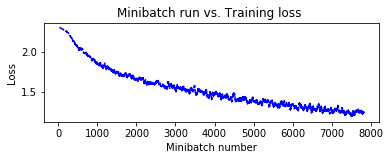

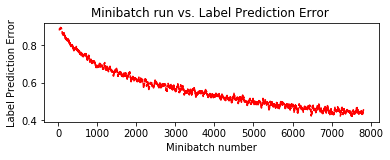

In [59]:
pred_basic_model_dropout= train_and_evaluate(reader_train, reader_test, max_epochs=10, model_func=create_basic_model_with_dropout)

In [60]:
#CNN Model with Batch Normalization(BN)
def create_basic_model_with_batch_normalization(input,out_dims):
    with C.layers.default_options(activation=C.relu, init=C.glorot_uniform()):
        model= C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution((5,5), (32,32,64)[i], pad=True),
                C.layers.BatchNormalization(map_rank=1),
                C.layers.MaxPooling((3,3), strides=(2,2))
                
            ]),
            C.layers.Dense(64),
            C.layers.BatchNormalization(map_rank=1),
            C.layers.Dense(out_dims, activation=None)
        ])
    return model(input)


Training 117290 parameters in 18 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per 64 samples: 0.9
Finished Epoch[1 of 10]: [Training] loss = 1.585962 * 50000, metric = 56.99% * 50000 50.389s (992.3 samples/s);
Finished Epoch[2 of 10]: [Training] loss = 1.256283 * 50000, metric = 44.76% * 50000 50.960s (981.2 samples/s);
Finished Epoch[3 of 10]: [Training] loss = 1.134634 * 50000, metric = 40.16% * 50000 54.769s (912.9 samples/s);
Finished Epoch[4 of 10]: [Training] loss = 1.048127 * 50000, metric = 37.14% * 50000 52.733s (948.2 samples/s);
Finished Epoch[5 of 10]: [Training] loss = 0.987400 * 50000, metric = 34.49% * 50000 55.047s (908.3 samples/s);
Finished Epoch[6 of 10]: [Training] loss = 0.940706 * 50000, metric = 33.04% * 50000 56.284s (888.4 samples/s);
Finished Epoch[7 of 10]: [Training] loss = 0.898735 * 50000, metric = 31.33% * 50000 53.796s (929.4 samples/s);
Finished Epoch[8 of 10]: [Training] loss = 0.859697 * 50000, metric = 29.78% * 50000 50.128s (997.4 

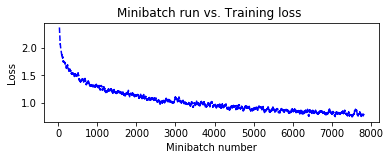

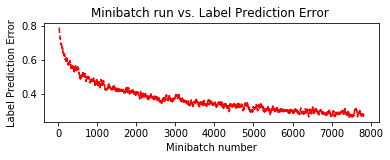

In [61]:
pred_basic_model_dropout= train_and_evaluate(reader_train, reader_test, max_epochs=10, model_func=create_basic_model_with_batch_normalization)

In [69]:
#VGG style network model

def create_vgg9_model(input, out_dims):
    with C.layers.default_options(activation=C.relu, init= C.glorot_uniform()):
        model=C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution2D((3,3), [64,96,128][i], pad=True),
                C.layers.Convolution2D((3,3), [64,96,128][i], pad=True),
                C.layers.MaxPooling((3,3), strides=(2,2))
            ]),
            C.layers.For(range(2), lambda: [
                C.layers.Dense(1024)
            ]),
            C.layers.Dense(out_dims, activation=None)
        ])
    return model(input)



Training 2675978 parameters in 18 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per 64 samples: 0.9
Finished Epoch[1 of 10]: [Training] loss = 2.267282 * 50000, metric = 83.17% * 50000 236.485s (211.4 samples/s);
Finished Epoch[2 of 10]: [Training] loss = 1.880069 * 50000, metric = 70.72% * 50000 233.301s (214.3 samples/s);
Finished Epoch[3 of 10]: [Training] loss = 1.675553 * 50000, metric = 62.52% * 50000 231.289s (216.2 samples/s);
Finished Epoch[4 of 10]: [Training] loss = 1.556934 * 50000, metric = 57.35% * 50000 234.982s (212.8 samples/s);
Finished Epoch[5 of 10]: [Training] loss = 1.451484 * 50000, metric = 53.07% * 50000 235.197s (212.6 samples/s);
Finished Epoch[6 of 10]: [Training] loss = 1.365178 * 50000, metric = 49.49% * 50000 236.905s (211.1 samples/s);
Finished Epoch[7 of 10]: [Training] loss = 1.284541 * 50000, metric = 46.30% * 50000 239.007s (209.2 samples/s);
Finished Epoch[8 of 10]: [Training] loss = 1.204207 * 50000, metric = 43.08% * 50000 226.577

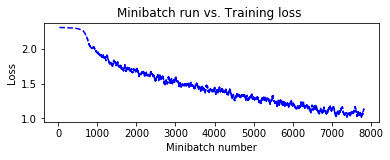

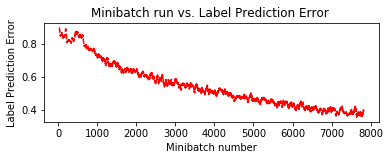

In [70]:
pred_basic_model_dropout= train_and_evaluate(reader_train, reader_test, max_epochs=10, model_func=create_vgg9_model)

In [71]:
#Residual Network (ResNet)
# Figure 7
Image(url="https://cntk.ai/jup/201/ResNetBlock2.png")

In [72]:
       ResNetNode                   ResNetNodeInc
            |                              |
     +------+------+             +---------+----------+
     |             |             |                    |
     V             |             V                    V
+----------+       |      +--------------+   +----------------+
| Conv, BN |       |      | Conv x 2, BN |   | SubSample, BN  |
+----------+       |      +--------------+   +----------------+
     |             |             |                    |
     V             |             V                    |
 +-------+         |         +-------+                |
 | ReLU  |         |         | ReLU  |                |
 +-------+         |         +-------+                |
     |             |             |                    |
     V             |             V                    |
+----------+       |        +----------+              |
| Conv, BN |       |        | Conv, BN |              |
+----------+       |        +----------+              |
     |             |             |                    |
     |    +---+    |             |       +---+        |
     +--->| + |<---+             +------>+ + +<-------+
          +---+                          +---+
            |                              |
            V                              V
        +-------+                      +-------+
        | ReLU  |                      | ReLU  |
        +-------+                      +-------+
            |                              |
            V                              V

SyntaxError: invalid syntax (<ipython-input-72-bc85417e0e0f>, line 1)

In [81]:
def convolution_bn(input, filter_size, num_filters, strides=(1,1), init=C.he_normal(), activation=C.relu):
    if activation is None:
        activation =lambda x:x
        
    r=C.layers.Convolution(filter_size,
                          num_filters,
                          strides=strides,
                          init=init,
                          activation=None,
                          pad=True,
                          bias=False)(input)
    r=C.layers.BatchNormalization(map_rank=1)(r)
    r=activation(r)
    
    return r

def resnet_basic(input, num_filters):
    c1=convolution_bn(input, (3,3), num_filters)
    c2=convolution_bn(c1, (3,3), num_filters, activation=None)
    p=c2+input
    
    return C.relu(p)

def resnet_basic_inc(input, num_filters):
    c1 =convolution_bn(input, (3,3), num_filters, strides=(2,2))
    c2=convolution_bn(c1, (3,3), num_filters, activation=None)
    
    s= convolution_bn(input, (1,1), num_filters, strides=(2,2), activation=None)
    
    p=c2+s
    return C.relu(p)

def resnet_basic_stack(input, num_filters, num_stack):
    assert (num_stack>0)
    
    r= input
    for _ in range(num_stack):
        r= resnet_basic(r, num_filters)
    
    return r 

In [84]:
#Writing the full model
def create_resnet_model(input, out_dims):
    conv=convolution_bn(input, (3,3), 16)
    r1_1=resnet_basic_stack(conv, 16, 3)
    
    r2_1=resnet_basic_inc(r1_1, 32)
    r2_2=resnet_basic_stack(r2_1, 32, 2)
    
    r3_1=resnet_basic_inc(r2_2, 64)
    r3_2=resnet_basic_stack(r3_1, 64, 2)
    
    #Global average pooling
    pool =C.layers.AveragePooling(filter_shape=(8,8), strides=(1,1))(r3_2)
    net=C.layers.Dense(out_dims, init=C.he_normal(), activation=None)(pool)
    
    return net

Training 272474 parameters in 65 parameter tensors.

Learning rate per minibatch: 0.01
Momentum per 64 samples: 0.9
Finished Epoch[1 of 5]: [Training] loss = 1.866173 * 50000, metric = 70.05% * 50000 526.610s ( 94.9 samples/s);
Finished Epoch[2 of 5]: [Training] loss = 1.534665 * 50000, metric = 56.82% * 50000 264.322s (189.2 samples/s);
Finished Epoch[3 of 5]: [Training] loss = 1.407519 * 50000, metric = 51.42% * 50000 263.510s (189.7 samples/s);
Finished Epoch[4 of 5]: [Training] loss = 1.313961 * 50000, metric = 47.72% * 50000 249.967s (200.0 samples/s);
Finished Epoch[5 of 5]: [Training] loss = 1.231082 * 50000, metric = 44.35% * 50000 249.994s (200.0 samples/s);

Final Results: Minibatch[1-626]: errs = 41.5% * 10000



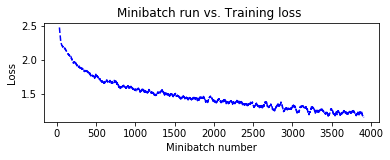

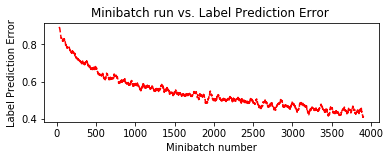

In [85]:
pred_resnet = train_and_evaluate(reader_train, reader_test, max_epochs=5, model_func=create_resnet_model)